# Seq2Seq

*Sequence to Sequence*.  
*Encoder-Decoder Model*とも。

2つのモデルを用いて、入力されたシーケンスに基づいた別のシーケンスを出力するモデル。

In [1]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings; warnings.filterwarnings('ignore')
import math
import random
import time

import tensorflow as tf
import tensorflow_datasets as tfds
import sentencepiece as spm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from dlprog import train_progress

In [2]:
prog = train_progress(
    width=20,
    with_test=True,
    label="ppl train",
    round=2,
    agg_fn=lambda s, w: math.exp(s / w)
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')


---

## Seq2Seqの発想

これまで、RNNを用いて、入力した単語列に続く単語を予測するモデルを作成し、単語の予測を繰り返すことで文章を生成した。

RNNは時系列の情報を保持するために隠れ状態$h_t$を用いる。隠れ状態の初期値$h_0$は0ベクトルとしているが、ここで、何らかの入力データから生成したベクトルを$h_0$として用いることを考える。このとき、上手く学習させれば、その入力に基づいた文章を生成できるのではないか。

例えば、入力を画像をとし、CNNを用いて抽出した特徴量を$h_0$として用いるようにすれば、入力画像に基づいた文章が生成できる。画像のキャプション生成などに応用できそう。隠れ状態を通じてRNNからCNNまで逆伝播が繋がるので、画像と文章のペアさえ用意すれば学習できそう。というかできる[1]。

[1] [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555)

では、入力に文章を用いることはできないだろうか。RNNに文章を入力し、最後に出力された隠れ状態を文章ベクトルとする。これを別のRNNへの入力$h_0$とすれば、入力文に基づいた文章生成が可能になる。

この発想は翻訳タスクに大きく役立つ。入力と出力に同じ意味を持った異なる言語の文章を設定すれば、入力文と同じ意味を持った文章生成が可能になる。

本章ではこの翻訳モデルを作成する。入力に日本語文、出力に入力と同じ意味を持つ英語文を設定し、日本語→英語の翻訳を行うモデルを作成する。こういった、シーケンスをシーケンスに変換するモデルを *seq2seq (Sequence to Sequence)* と呼ぶ。

seq2seqは以下の二つのRNNから構成される。
- ***Encoder*** : 文章ベクトルを生成するRNN
- ***Decoder*** : 文章ベクトルを受け取って出力文を生成するRNN

このことから***Encoder-Decoderモデル***とも呼ばれる。


---

## 対訳コーパス

翻訳モデルを作るには、同じ意味を持つ文章が複数の言語でまとまっているデータが必要。このようなデータは対訳コーパスと呼んだりする。

本章では以下のデータセットを使用する。
- [iwslt2017  |  TensorFlow Datasets](https://www.tensorflow.org/datasets/community_catalog/huggingface/iwslt2017?hl=ja#iwslt2017-en-ja)

In [ ]:
ds = tfds.load(
    "huggingface:iwslt2017/iwslt2017-en-ja",
    data_dir="data",
    split="train"
)
ds = list(ds.as_numpy_iterator())

In [4]:
data_ja = []
data_en = []
for sample in ds:
    ja = sample["translation"]["ja"].decode()
    en = sample["translation"]["en"].decode()
    data_ja.append(ja)
    data_en.append(en)

print("num of data:", len(data_ja), "\n")
for _ in range(5):
    i = random.randint(0, len(data_ja))
    print(data_ja[i])
    print(data_en[i])
    print()

num of data: 223108 

これで解ったのは 皆が実際に見たものではなく 皆の記憶に残ったことを 再現すべきだという事です
And what I discovered is, what I should do is not actually replicate what they saw, is replicate what they remembered.

その時ちょうどモーセ五書のレビ記の一節を読んでいるところで
And as he was dozing off, they were reading from the book of Leviticus in the Torah.

非常にたくさんの根本的な社会活動が Googleの至る所に存在します それらは会社が活動を支援するために 社会的責任チームを 結成することにしたものです
There is so much organic social action all around Google that the company decided to form a social responsibility team just to support these efforts.

だから 驚いたよ
So I'm surprised.

こんなセリフがありましたね
These are the next two lines in the movie.



書き出し

In [5]:
textfile_ja = 'data/iwslt2017_ja.txt'
with open(textfile_ja, 'w') as f:
    f.write('\n'.join(data_ja))

textfile_en = 'data/iwslt2017_en.txt'
with open(textfile_en, 'w') as f:
    f.write('\n'.join(data_en))

読み込み

In [3]:
textfile_ja = f"data/iwslt2017_ja.txt"
textfile_en = f"data/iwslt2017_en.txt"
tokenizer_prefix_ja = f"models/tokenizer_iwslt2017_ja"
tokenizer_prefix_en = f"models/tokenizer_iwslt2017_en"

with open(textfile_ja) as f:
    data_ja = f.read().splitlines()
with open(textfile_en) as f:
    data_en = f.read().splitlines()

データ数を減らしたものも作っておく。

In [6]:
# n_data = 100000
# data_ja = data_ja[:n_data]
# data_en = data_en[:n_data]
# textfile_ja = f'data/iwslt2017_ja_{n_data}.txt'
# textfile_en = f'data/iwslt2017_en_{n_data}.txt'
# tokenizer_prefix_ja = f"models/tokenizer_iwslt2017_ja_{n_data}"
# tokenizer_prefix_en = f"models/tokenizer_iwslt2017_en_{n_data}"

# with open(textfile_ja, 'w') as f:
#     f.write('\n'.join(data_ja))

# with open(textfile_en, 'w') as f:
#     f.write('\n'.join(data_en))

トークナイザの学習。

In [ ]:
# pad_id = 3
# vocab_size = 8000

# spm.SentencePieceTrainer.Train(
#     input=textfile_ja,
#     model_prefix=tokenizer_prefix_ja,
#     vocab_size=vocab_size,
#     pad_id=pad_id
# )

# spm.SentencePieceTrainer.Train(
#     input=textfile_en,
#     model_prefix=tokenizer_prefix_en,
#     vocab_size=vocab_size,
#     pad_id=pad_id
# )

読み込み

In [4]:
# n_data = 100000
# textfile_ja = f"data/iwslt2017_ja_{n_data}.txt"
# textfile_en = f"data/iwslt2017_en_{n_data}.txt"
# tokenizer_prefix_ja = f"models/tokenizer_iwslt2017_ja_{n_data}"
# tokenizer_prefix_en = f"models/tokenizer_iwslt2017_en_{n_data}"

# with open(textfile_ja) as f:
#     data_ja = f.read().splitlines()
# with open(textfile_en) as f:
#     data_en = f.read().splitlines()

### 前処理

トークナイザ読み込み

In [4]:
sp_ja = spm.SentencePieceProcessor(f"{tokenizer_prefix_ja}.model")
sp_en = spm.SentencePieceProcessor(f"{tokenizer_prefix_en}.model")

unk_id = sp_ja.unk_id()
bos_id = sp_ja.bos_id()
eos_id = sp_ja.eos_id()
pad_id = sp_ja.pad_id()

n_vocab_ja = len(sp_ja)
n_vocab_en = len(sp_en)
print("num of vocabrary (ja):", n_vocab_ja)
print("num of vocabrary (en):", n_vocab_en)

num of vocabrary (ja): 8000
num of vocabrary (en): 8000


トークン化

In [5]:
data_ids_ja = sp_ja.encode(data_ja)
data_ids_en = sp_en.encode(data_en)

BOS, EOSの追加

In [6]:
for ids_ja, ids_en in zip(data_ids_ja, data_ids_en):
    ids_en.insert(0, bos_id)
    ids_ja.append(eos_id)
    ids_en.append(eos_id)

### 学習データの作成

入力文と正解のペアを作成する。

Encoderへの入力（入力文）とDecoderの出力（正解）のペアを作成する。  
また、Decoderへの入力を考える必要がある。今回は教師強制を採用し、出力文の頭に\<BOS>を付与したものをDecoderへの入力とする。

例）
Encoderへの入力（入力文） | Decoderへの入力 | Eecoderの出力（出力文）
--- | --- | ---
夏 休み が 終わり ました 。 \<EOS> | \<BOS> Summer vacation is over . | Summer vacation is over . \<EOS>
ツイッター は 亡くなり ました 。 \<EOS> | \<BOS> Twitter is dead . | Twitter is dead . \<EOS>
今日 から X で 暮らし ましょう 。 \<EOS> | \<BOS> Let 's live in X from today . | Let 's live in X from today . \<EOS>

DataLoaderの作成。

In [7]:
class TextDataset(Dataset):
    def __init__(self, data_ids_ja, data_ids_en):
        self.data_ja = [torch.tensor(ids) for ids in data_ids_ja]
        self.data_en = [torch.tensor(ids) for ids in data_ids_en]
        self.n_data = len(self.data_ja)

    def __getitem__(self, idx):
        ja = self.data_ja[idx]
        en = self.data_en[idx]
        x_enc = ja # encoderへの入力
        x_dec = en[:-1] # decoderへの入力
        y_dec = en[1:] # decoderの出力
        return x_enc, x_dec, y_dec

    def __len__(self):
        return self.n_data

def collate_fn(batch): # padding
    x_enc, x_dec, y_dec= zip(*batch)
    x_enc = pad_sequence(x_enc, batch_first=True, padding_value=pad_id)
    x_dec = pad_sequence(x_dec, batch_first=True, padding_value=pad_id)
    y_dec = pad_sequence(y_dec, batch_first=True, padding_value=pad_id)
    return x_enc, x_dec, y_dec

dataset = TextDataset(data_ids_ja, data_ids_en)
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print("num of train data:", len(train_dataset))
print("num of test data:", len(test_dataset))

batch_size = 32
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=collate_fn
)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    drop_last=True,
    collate_fn=collate_fn
)

# example
x_enc, x_dec, y_dec = next(iter(train_loader))
x_enc.shape, x_dec.shape, y_dec.shape

num of train data: 178487
num of test data: 44621


(torch.Size([32, 55]), torch.Size([32, 63]), torch.Size([32, 63]))


---

## Seq2Seqを用いた翻訳モデル

### Encoder

入力文を入れて隠れ状態を出力するだけのRNN。LSTMと線形層で作る。

ここで1つ工夫を加える。普通に作っても動きはするが、学習が上手くいかない可能性がある。

学習時にencoderへ入力されるデータはpaddingされたデータとなる。ここで、paddingされた範囲が多い=padトークンが多く含まれているデータは、padの数が多くなるにつれて、隠れ状態がある一定の値に収束してしまう。RNNに同じトークンを何度も入力することで隠れ状態が収束してしまうのだ。そうなってしまうと、入力文に依る隠れ状態の違いが少なくなり、翻訳を学習できない。

そこで、encoderが出力する隠れ状態として、padトークンを除いた最後のトークン=EOSを入力した時点のものを使用する。  

以上を踏まえ、encoderを以下のように実装する。

In [8]:
class Encoder(nn.Module):
    def __init__(
        self,
        n_vocab,
        embed_size,
        hidden_size,
        num_layers=3,
        dropout=0.2,
    ):
        super().__init__()
        self.embedding = nn.Embedding(n_vocab, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
            bidirectional=True,
        )
        self.fc = nn.Linear(hidden_size * 2, hidden_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        x: (batch_size, seq_len)
        """
        # eos_positions = x == eos_id
            # eosに対応する位置のみがTrueとなったTensor: (batch_size, seq_len)
        x = self.embedding(x) # (batch_size, seq_len, embed_size)
        _, (h, _) = self.lstm(x) # (num_layers * 2, batch_size, hidden_size)
        # h = hs[eos_positions] # (batch_size, hidden_size)
        h_forward = h[-2] # (batch_size, hidden_size)
        h_backward = h[-1] # (batch_size, hidden_size)
        h = torch.cat([h_forward, h_backward], dim=-1)
            # (batch_size, hidden_size * 2)
        h = self.fc(h) # (batch_size, hidden_size)
        h = self.tanh(h)
        return h

In [28]:
class Encoder(nn.Module):
    def __init__(
        self,
        n_vocab,
        embed_size,
        hidden_size,
        num_layers=3,
        dropout=0.2,
    ):
        super().__init__()
        self.embedding = nn.Embedding(n_vocab, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, hidden_size)
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        x: (batch_size, seq_len)
        """
        eos_positions = x == eos_id
            # eosに対応する位置のみがTrueとなったTensor: (batch_size, seq_len)
        x = self.embedding(x) # (batch_size, seq_len, embed_size)
        hs, _ = self.lstm(x) # (batch_size, seq_len, hidden_size)
        h = hs[eos_positions] # (batch_size, hidden_size)
        h = self.fc(h) # (batch_size, hidden_size)
        h = self.tanh(h)
        return h

### Decoder

Encoderから出力された隠れ状態を受け取り、出力文を生成するRNN。Encoder同様、LSTMと線形層で作る。

In [9]:
class Decoder(nn.Module):
    def __init__(
        self,
        n_vocab,
        embed_size,
        hidden_size,
        num_layers=3,
        dropout=0.2,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.embedding = nn.Embedding(n_vocab, embed_size)
        self.lstm = nn.LSTM(
            embed_size,
            hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_size, n_vocab)

    def forward(self, x, hc):
        x = self.embedding(x) # (batch_size, seq_len, embed_size)
        hs, hc = self.lstm(x, hc) # (batch_size, seq_len, hidden_size)
        y = self.fc(hs) # (batch_size, seq_len, n_vocab)
        return y, hc

### Seq2Seq

EncoderとDecoderを合わせて、入力から出力までの一連の処理を行うモデルを作る。

In [10]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x_enc, x_dec):
        h = self.encoder(x_enc)
        hc = self.get_hc(h)
        y, _ = self.decoder(x_dec, hc)
        return y

    def get_hc(self, h_enc):
        h = torch.stack([h_enc for _ in range(self.decoder.num_layers)], dim=0)
            # (num_decoder_layers, batch_size, hidden_size)
        c = torch.zeros_like(h)
        hc = (h, c)
        return hc

In [11]:
hidden_size, embed_size = 512, 512
encoder = Encoder(n_vocab_ja, embed_size, hidden_size)
decoder = Decoder(n_vocab_en, embed_size, hidden_size)
model = Seq2Seq(encoder, decoder).to(device)
n_params = sum(p.numel() for p in model.parameters())
print(f"num of parameters: {n_params:,}")

num of parameters: 35,926,336



---

## 実践

### 学習

In [12]:
cross_entropy = nn.CrossEntropyLoss(ignore_index=pad_id)
def loss_fn(y, t):
    loss = cross_entropy(y.reshape(-1, n_vocab_ja), t.ravel())
    return loss

@torch.no_grad()
def eval_model(model):
    model.eval()
    losses = []
    for x_enc, x_dec, y_dec in test_loader:
        x_enc = x_enc.to(device)
        x_dec = x_dec.to(device)
        y_dec = y_dec.to(device)

        y = model(x_enc, x_dec)
        loss = loss_fn(y, y_dec)
        losses.append(loss.item())
    loss = sum(losses) / len(losses)
    ppl = math.exp(loss)
    return ppl

inf_times = []
loss_times = []
backward_times = []
optim_times = []
prog_times = []
step_times = []

def train(model, optimizer, n_epochs, prog_unit=1):
    prog.start(n_iter=len(train_loader), n_epochs=n_epochs, unit=prog_unit)
    for _ in range(n_epochs):
        model.train()
        for x_enc, x_dec, y_dec in train_loader:
            start_time = prog.now_time
            optimizer.zero_grad()
            x_enc = x_enc.to(device)
            x_dec = x_dec.to(device)
            y_dec = y_dec.to(device)

            inf_start = time.time()
            y = model(x_enc, x_dec)
            inf_times.append(time.time() - inf_start)

            loss_start = time.time()
            loss = loss_fn(y, y_dec)
            loss_times.append(time.time() - loss_start)

            backward_start = time.time()
            loss.backward()
            backward_times.append(time.time() - backward_start)

            optim_start = time.time()
            optimizer.step()
            optim_times.append(time.time() - optim_start)

            prog_start = time.time()
            prog.update(loss.item())
            prog_times.append(time.time() - prog_start)

            step_times.append(time.time() - start_time)

        if prog.now_epoch % prog_unit == 0:
            test_ppl = eval_model(model)
            prog.memo(f"test: {test_ppl:.2f}", no_step=True)
        prog.memo()

In [13]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [14]:
train(model, optimizer, n_epochs=20, prog_unit=1)

 1/20: #################### 100% [00:05:44.69] ppl train: 215.69, test: 133.62 
 2/20: #################### 100% [00:05:41.32] ppl train: 115.04, test: 98.79 
 3/20: #################### 100% [00:05:40.19] ppl train: 91.90, test: 85.68 
 4/20: #################### 100% [00:05:39.83] ppl train: 80.69, test: 77.28 
 5/20: #################### 100% [00:05:38.26] ppl train: 72.38, test: 70.82 
 6/20: #################### 100% [00:05:39.26] ppl train: 65.66, test: 65.72 
 7/20: #################### 100% [00:05:38.57] ppl train: 60.25, test: 61.72 
 8/20: #################### 100% [00:05:37.67] ppl train: 55.83, test: 58.55 
 9/20: #################### 100% [00:05:39.43] ppl train: 51.99, test: 56.16 
10/20: #################### 100% [00:05:39.01] ppl train: 48.63, test: 53.91 
11/20: #################### 100% [00:05:38.37] ppl train: 45.70, test: 52.22 
12/20: #################### 100% [00:05:38.70] ppl train: 43.05, test: 50.83 
13/20: #################### 100% [00:05:38.90] ppl train: 40.

処理時間

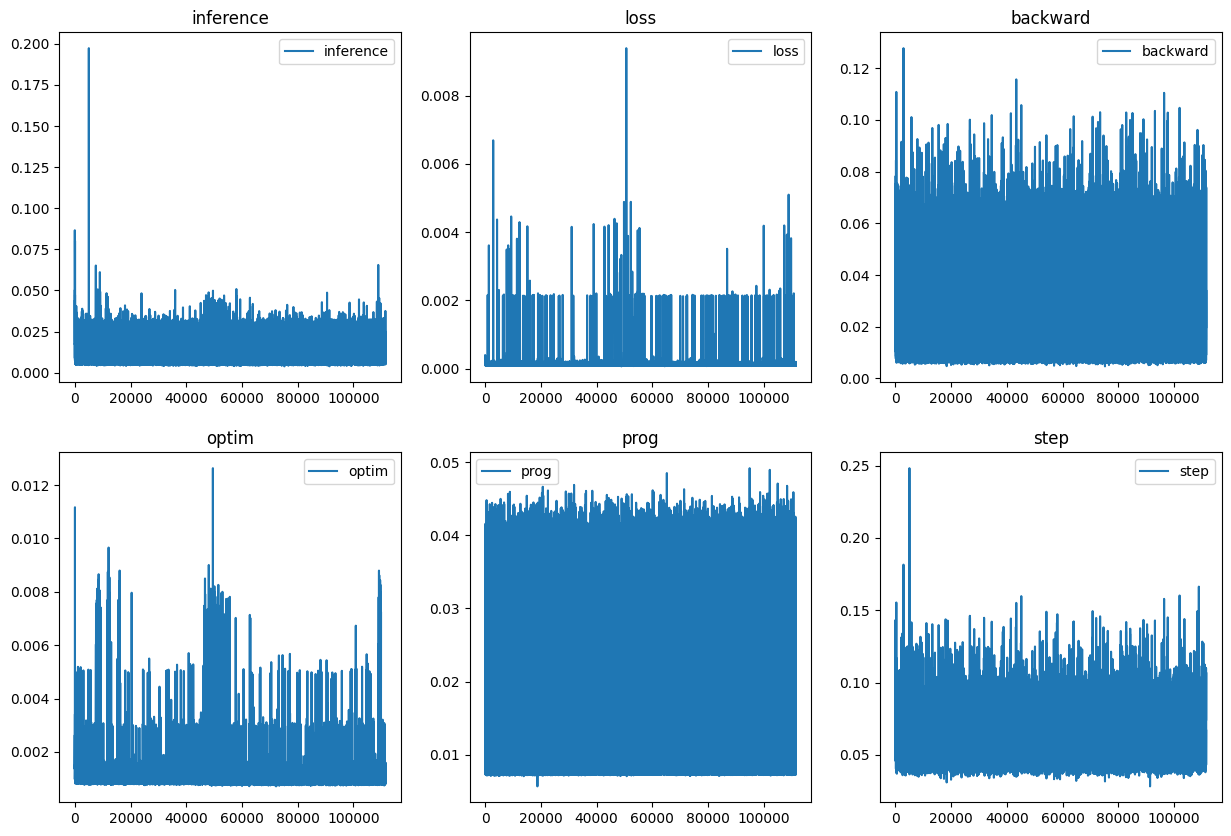

In [25]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for ax, times, label in zip(
    axes,
    [inf_times, loss_times, backward_times, optim_times, prog_times, step_times],
    ["inference", "loss", "backward", "optim", "prog", "step"]
):
    ax.plot(times[5:], label=label)
    ax.legend()
    ax.set_title(label)

In [26]:
model_path = "models/lm_seq2seq_bilstm.pth"
torch.save(model.state_dict(), model_path)

### 翻訳

作成したモデルに日本語文を入力し、英語に翻訳して出力する。

In [21]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [16]:
def token_sampling(y, decisive=True):
    y.squeeze_(0)
    if decisive:
        token = y.argmax().item()
    else:
        y[unk_id] = -torch.inf
        probs = F.softmax(y, dim=-1)
        token, = random.choices(range(n_vocab_en), weights=probs)
    return token


bos_id = sp_en.bos_id()
eos_id = sp_en.eos_id()
@torch.no_grad()
def translate(
    model: nn.Module,
    in_text: str, # 入力文（日本語）
    max_len: int = 100, # 出力のトークン数の上限
    decisive: bool = True, # サンプリングを決定的にするか
) -> str:
    model.eval()
    in_ids = sp_ja.encode(in_text)
    in_ids = torch.tensor(in_ids + [eos_id], device=device).unsqueeze(0)

    h_enc = model.encoder(in_ids)
    hc = model.get_hc(h_enc)
    next_token = bos_id

    token_ids = []
    while len(token_ids) <= max_len and next_token != eos_id:
        x = torch.tensor([next_token], device=device).reshape(1, 1)
        y, hc = model.decoder(x, hc)
        next_token = token_sampling(y, decisive)
        token_ids.append(next_token)

    sentence = sp_en.decode(token_ids)
    return sentence

まずは訓練データから。

In [17]:
n = 5
for _ in range(n):
    i = random.randint(0, len(train_dataset))
    x, _, t = train_dataset[i]
    x = sp_ja.decode(x.tolist())
    t = sp_en.decode(t.tolist())
    print("input:", x)
    print("output:", translate(model, x))
    print("answer:", t)
    print()

input: あなたもずっとケビンと呼ばれてきましたか?
output: Who's been a great friend?
answer: Have you been called Kevin all your life?

input: 従来専門家とは 高度な学位や 派手な肩書き、 ディプロマなどを持ったり ベストセラー本を書いた
output: The first is that the Internet is a very good person, and you're going to have to be a professional person, and you're going to have a new website, and you're going to have to go to the website.
answer: The conventional notion is that experts are people with advanced degrees, fancy titles, diplomas, best-selling books -- high-status individuals.

input: 都市の形だけでなく 感情を吹き込んだという事実が重要です 都市を造る人の感情だけでなく そこに住む人の感情についても...
output: It's not just a place where we're not going to be able to do it, but it's a very good thing to do with the Internet, but it's also a very good thing to do with the community.
answer: It's not only the forms of cities, but the fact that they incarnate emotions, not just of those who build them, but of those who live there as well.

input: 5 年間にわたり
output: I've been working on the last 10 years.

訓練データに含まれていないものも試してみる。

In [18]:
# test data
for _ in range(n):
    i = random.randint(0, len(test_dataset))
    x, _, t = test_dataset[i]
    x = sp_ja.decode(x.tolist())
    t = sp_en.decode(t.tolist())
    print('input:', x)
    print('output:', translate(model, x))
    print('answer:', t)
    print()

input: 彼らはとてもタチの悪い情報のもとに 非常に誤った決断をしたことで 想像を絶する結果を 抱えながら生きています その情報は 心ない人々によって持ち込まれました 彼らは自分たちの引き起こした悲劇を 重々承知していますが それを気には留めていないのです
output: They're not really interested in their own ideas, but they're not just trying to get them to do their own, and they're not going to get the same results, and they're also trying to figure out how to do this, and they're going to be able to do that, and they're going to be able to do that.
answer: They're just living with the unimaginable consequences of a very bad decision, made based on very bad information that was put into their minds by very bad people, who know good and well the misery that they're causing, but just don't care.

input: お金は重要です
output: The problem is that it's not.
answer: But I worry because this money is so important.

input: 1つ目はファンディ湾のケースです
output: The first one was the first one.
answer: The first case comes from the Bay of Fundy.

input: 私はウォーリーを 探しているように見えました
output: I was in the middle of the water.
answer: I looked like

In [19]:
# original
sentences = [
    'ありがとう。',
    '猫はかわいいね。',
    '上手く文章が書けるようになりました。'
]

for sentence in sentences:
    print('input:', sentence)
    print('output:', translate(model, sentence))
    print()

input: ありがとう。
output: Thank you.

input: 猫はかわいいね。
output: It's got a little bit of water.

input: 上手く文章が書けるようになりました。
output: And so, they were really excited about this.

